# Titanic Baseline Model

## Strategy
- Use the strongest predictors identified in EDA: Sex and Pclass
- Handle missing values appropriately
- Use gradient boosting (XGBoost) as primary model
- 5-fold stratified cross-validation

## Key Findings from EDA
- Gender effect: Female 74.2% vs Male 18.9% survival
- Pclass gradient: 1st (63%), 2nd (47%), 3rd (24%) survival
- Missing data: Age (20%), Cabin (77%), Embarked (0.2%)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load data
train = pd.read_csv('/home/data/train.csv')
test = pd.read_csv('/home/data/test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nMissing values in train:")
print(train.isnull().sum()[train.isnull().sum() > 0])

Train shape: (891, 12)
Test shape: (418, 11)

Missing values in train:
Age         177
Cabin       687
Embarked      2
dtype: int64


In [4]:
# Feature engineering function
def engineer_features(df):
    """Engineer features for Titanic dataset"""
    df = df.copy()
    
    # Basic features
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    
    # Fill missing Age with median
    df['Age'].fillna(df['Age'].median(), inplace=True)
    
    # Create Age groups
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], 
                           labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])
    df['AgeGroup'] = df['AgeGroup'].cat.codes
    
    # Family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Fill missing Embarked with mode
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    # Fill missing Fare with median
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    # Extract title from name
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 
                                     'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
    df['Title'].fillna(0, inplace=True)
    
    # Cabin deck
    df['CabinDeck'] = df['Cabin'].str[0]
    df['CabinDeck'] = df['CabinDeck'].map({
        'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8
    })
    df['CabinDeck'].fillna(0, inplace=True)
    
    # Create interaction features
    df['ClassSex'] = df['Pclass'] * df['Sex']
    df['AgeClass'] = df['Age'] * df['Pclass']
    
    return df

# Engineer features
train_fe = engineer_features(train)
test_fe = engineer_features(test)

# Select features for modeling
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 
           'Title', 'CabinDeck', 'AgeGroup', 'ClassSex', 'AgeClass']

X = train_fe[features]
y = train_fe['Survived']
X_test = test_fe[features]

print(f"Feature matrix shape: {X.shape}")
print(f"Test matrix shape: {X_test.shape}")

Feature matrix shape: (891, 12)
Test matrix shape: (418, 12)


In [6]:
# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',
    'device': 'cpu',
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Cross-validation
cv_scores = []
oof_predictions = np.zeros(len(X))
test_predictions = np.zeros(len(X_test))

print("Starting 5-fold cross-validation...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Create DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    # Train model
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=200,
        evals=[(dval, 'val')],
        verbose_eval=False
    )
    
    # Predictions
    val_pred = model.predict(dval)
    val_pred_binary = (val_pred > 0.5).astype(int)
    
    test_pred = model.predict(dtest)
    
    # Store predictions
    oof_predictions[val_idx] = val_pred
    test_predictions += test_pred / 5
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, val_pred_binary)
    cv_scores.append(accuracy)
    
    print(f"Fold {fold + 1}: Accuracy = {accuracy:.4f}")

print(f"\nCV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

Starting 5-fold cross-validation...
Fold 1: Accuracy = 0.8771


Fold 2: Accuracy = 0.8539
Fold 3: Accuracy = 0.8034


Fold 4: Accuracy = 0.8202
Fold 5: Accuracy = 0.8427

CV Accuracy: 0.8395 ± 0.0257


Top 10 Most Important Features:
       feature  importance
7        Title    6.917448
0       Pclass    6.740780
10    ClassSex    5.199034
1          Sex    5.146847
5   FamilySize    1.597878
8    CabinDeck    1.533926
3         Fare    1.354555
11    AgeClass    1.322190
9     AgeGroup    1.181950
4     Embarked    1.122752


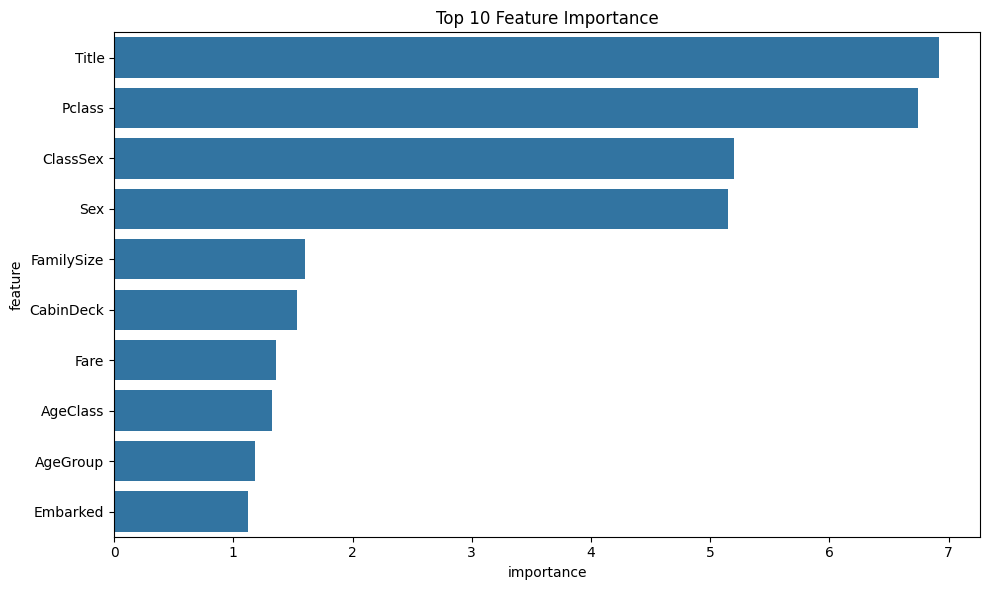

In [8]:
# Feature importance
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = model.get_score(importance_type='gain')
features_list = list(feature_importance.keys())
importance_values = list(feature_importance.values())

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': features_list,
    'importance': importance_values
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

In [9]:
# Create submission
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': (test_predictions > 0.5).astype(int)
})

submission_path = '/home/submission/submission_001_baseline.csv'
submission.to_csv(submission_path, index=False)

print(f"Submission saved to: {submission_path}")
print(f"Submission shape: {submission.shape}")
print("\nSubmission preview:")
print(submission.head())

# Check distribution
print(f"\nSurvival prediction distribution:")
print(submission['Survived'].value_counts())

Submission saved to: /home/submission/submission_001_baseline.csv
Submission shape: (418, 2)

Submission preview:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

Survival prediction distribution:
Survived
0    233
1    185
Name: count, dtype: int64
